# Notebook 2 : Transformer sur séquence de spikes

## Approche

On traite chaque fenêtre de 108ms comme une **séquence chronologique de spikes**. Chaque spike est encodé par un petit CNN 1D (spécifique à son shank), puis enrichi avec un embedding de shank et un positional encoding. La séquence est traitée par un Transformer encoder.

**Pourquoi un Transformer ?** L'information spatiale dans l'hippocampe est codée par des *ensembles de neurones* (population coding). Le mécanisme de self-attention permet à chaque spike de "voir" tous les autres et de capturer les co-activations entre shanks. C'est impossible avec un simple average pooling.

**Framework** : PyTorch, accéléré sur MPS (Apple Silicon).

## 1. Imports et configuration

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# Reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print(f'Device: {DEVICE}')

In [ ]:
# --- Connexion S3 (Onyxia) ou chargement local ---
S3_ENDPOINT = "https://minio.lab.sspcloud.fr"
S3_BUCKET = "gmarguier"
S3_PREFIX = "hacktion-potential"

PARQUET_NAME = "M1199_PAG_stride4_win108_test.parquet"
JSON_NAME = "M1199_PAG.json"

LOCAL_DIR = os.path.abspath('..')
LOCAL_PARQUET = os.path.join(LOCAL_DIR, PARQUET_NAME)
LOCAL_JSON = os.path.join(LOCAL_DIR, JSON_NAME)

USE_S3 = False
fs = None

try:
    import s3fs
    fs = s3fs.S3FileSystem(
        client_kwargs={"endpoint_url": S3_ENDPOINT},
        key=os.environ.get("AWS_ACCESS_KEY_ID"),
        secret=os.environ.get("AWS_SECRET_ACCESS_KEY"),
        token=os.environ.get("AWS_SESSION_TOKEN"),
    )
    s3_parquet = f"{S3_BUCKET}/{S3_PREFIX}/{PARQUET_NAME}"
    if fs.exists(s3_parquet):
        USE_S3 = True
        print(f"[S3] Connexion OK — lecture depuis s3://{S3_BUCKET}/{S3_PREFIX}/")
    else:
        print(f"[S3] Bucket accessible mais fichier introuvable ({s3_parquet})")
except Exception as e:
    print(f"[S3] Non disponible ({type(e).__name__}: {e})")

if not USE_S3:
    if os.path.exists(LOCAL_PARQUET):
        print(f"[LOCAL] Chargement depuis {LOCAL_DIR}/")
    else:
        raise FileNotFoundError(f"Données introuvables ni sur S3 ni en local ({LOCAL_PARQUET})")

## 2. Chargement et filtrage

In [ ]:
print('Chargement...')
if USE_S3:
    with fs.open(f"{S3_BUCKET}/{S3_PREFIX}/{PARQUET_NAME}", "rb") as f:
        df = pd.read_parquet(f)
    with fs.open(f"{S3_BUCKET}/{S3_PREFIX}/{JSON_NAME}", "r") as f:
        params = json.load(f)
else:
    df = pd.read_parquet(LOCAL_PARQUET)
    with open(LOCAL_JSON, 'r') as f:
        params = json.load(f)

nGroups = params['nGroups']
nChannelsPerGroup = [params[f'group{g}']['nChannels'] for g in range(nGroups)]
print(f'nGroups={nGroups}, nChannelsPerGroup={nChannelsPerGroup}')

# Filtrage speedMask
speed_masks = np.array([x[0] for x in df['speedMask']])
df_moving = df[speed_masks].reset_index(drop=True)
print(f'Exemples en mouvement : {len(df_moving)}')

## 3. Preprocessing : reconstruction de la séquence chronologique

Pour chaque fenêtre, on reconstruit la séquence ordonnée de spikes :
1. On reshape les waveforms de chaque shank : `groupX` → `(n_spikes, nCh, 32)`
2. On parcourt le tableau `groups` dans l'ordre chronologique
3. Pour chaque timestep, on récupère le waveform correspondant via `indicesX`
4. On ignore les indices à 0 (padding)

Le résultat : une liste de tuples `(waveform, shank_id)` ordonnée dans le temps.

Comme les shanks ont des nombres de canaux différents (6 ou 4), on utilise un **encodeur par shank** qui projette chaque waveform vers un espace commun de dimension D.

In [3]:
def reconstruct_sequence(row, nGroups, nChannelsPerGroup, max_seq_len=128):
    """
    Reconstruit la séquence chronologique de spikes.
    
    Retourne:
        waveforms_per_group: dict {g: np.array (n_spikes_g, nCh, 32)}
        sequence_groups: np.array (seq_len,) - quel shank à chaque timestep
        sequence_indices: np.array (seq_len,) - quel index de spike dans le shank
        seq_len: longueur effective de la séquence
    """
    groups = row['groups']
    length = min(len(groups), max_seq_len)
    
    # Reshape des waveforms par shank
    waveforms = {}
    for g in range(nGroups):
        nCh = nChannelsPerGroup[g]
        raw = row[f'group{g}']
        waveforms[g] = raw.reshape(-1, nCh, 32)
    
    # Reconstruction de la séquence
    seq_waveforms = []  # liste de (nCh, 32) - taille variable par spike
    seq_shank_ids = []
    
    for t in range(length):
        g = int(groups[t])
        idx = int(row[f'indices{g}'][t])
        if idx > 0 and idx <= waveforms[g].shape[0]:
            seq_waveforms.append((waveforms[g][idx - 1], g))  # idx est 1-based
            seq_shank_ids.append(g)
    
    return seq_waveforms, seq_shank_ids

# Test rapide
wf, sids = reconstruct_sequence(df_moving.iloc[0], nGroups, nChannelsPerGroup)
print(f'Premier exemple : {len(wf)} spikes réels dans la séquence')
print(f'Shanks utilisés : {set(sids)}')
print(f'Premier spike : shank={wf[0][1]}, shape={wf[0][0].shape}')

Premier exemple : 78 spikes réels dans la séquence
Shanks utilisés : {0, 1, 2, 3}
Premier spike : shank=1, shape=(4, 32)


## 4. Dataset PyTorch

Le Dataset gère :
- La reconstruction de séquence à la volée (pas besoin de stocker tout en mémoire)
- Le padding des waveforms à la taille max de canaux (6) pour pouvoir empiler dans un tenseur
- Le retour du masque de padding pour l'attention

On utilise un `collate_fn` custom pour gérer les séquences de longueur variable.

In [4]:
MAX_SEQ_LEN = 128  # On tronque les séquences trop longues (max observé = 190)
MAX_CHANNELS = max(nChannelsPerGroup)  # 6

class SpikeSequenceDataset(Dataset):
    def __init__(self, dataframe, nGroups, nChannelsPerGroup, max_seq_len=MAX_SEQ_LEN):
        self.df = dataframe
        self.nGroups = nGroups
        self.nChannelsPerGroup = nChannelsPerGroup
        self.max_seq_len = max_seq_len
        
        # Pré-extraire les targets
        self.targets = np.array([[x[0], x[1]] for x in dataframe['pos']], dtype=np.float32)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq, shank_ids = reconstruct_sequence(row, self.nGroups, self.nChannelsPerGroup, self.max_seq_len)
        
        seq_len = len(seq)
        if seq_len == 0:
            # Cas dégénéré : aucun spike valide
            seq_len = 1
            waveforms = np.zeros((1, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array([0], dtype=np.int64)
        else:
            # Padder les waveforms à MAX_CHANNELS canaux
            waveforms = np.zeros((seq_len, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array(shank_ids, dtype=np.int64)
            for t, (wf, g) in enumerate(seq):
                nCh = wf.shape[0]
                waveforms[t, :nCh, :] = wf
        
        target = self.targets[idx]
        return {
            'waveforms': torch.from_numpy(waveforms),      # (seq_len, MAX_CH, 32)
            'shank_ids': torch.from_numpy(shank_ids_arr),   # (seq_len,)
            'seq_len': seq_len,
            'target': torch.from_numpy(target)              # (2,)
        }


def collate_fn(batch):
    """Collate avec padding dynamique à la longueur max du batch."""
    max_len = max(item['seq_len'] for item in batch)
    batch_size = len(batch)
    
    waveforms = torch.zeros(batch_size, max_len, MAX_CHANNELS, 32)
    shank_ids = torch.zeros(batch_size, max_len, dtype=torch.long)
    mask = torch.ones(batch_size, max_len, dtype=torch.bool)  # True = padding (à ignorer)
    targets = torch.stack([item['target'] for item in batch])
    
    for i, item in enumerate(batch):
        sl = item['seq_len']
        waveforms[i, :sl] = item['waveforms']
        shank_ids[i, :sl] = item['shank_ids']
        mask[i, :sl] = False  # False = pas de padding
    
    return {
        'waveforms': waveforms,
        'shank_ids': shank_ids,
        'mask': mask,
        'targets': targets
    }

print('Dataset et collate_fn définis.')

Dataset et collate_fn définis.


## 5. Architecture du modèle

Le modèle a 4 composants :

1. **Spike Encoder** : un petit CNN 1D par shank qui projette chaque waveform `(nCh, 32)` vers un embedding de dimension D. Chaque shank a son propre encodeur car ils ont des géométries différentes.

2. **Shank Embedding** : un embedding appris (comme un "token type" en BERT) qui permet au modèle de savoir de quel shank provient chaque spike.

3. **Positional Encoding** : encoding sinusoïdal classique basé sur la position dans la séquence. Informe le modèle de l'ordre temporel des spikes.

4. **Transformer Encoder** : 2 couches de self-attention (4 heads, dim=64). Chaque spike peut "voir" tous les autres pour capturer les co-activations.

5. **Readout** : average pooling masqué (on ignore le padding) → couche Dense → (x, y).

In [5]:
class SpikeEncoder(nn.Module):
    """Encode un waveform (MAX_CH, 32) en un vecteur de dimension embed_dim.
    Utilise un CNN 1D sur la dimension temporelle (32 points)."""
    
    def __init__(self, n_channels, embed_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, embed_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # (batch, embed_dim, 1)
        )
    
    def forward(self, x):
        # x: (batch * seq_len, n_channels, 32)
        return self.conv(x).squeeze(-1)  # (batch * seq_len, embed_dim)


class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding."""
    
    def __init__(self, embed_dim, max_len=256):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, embed_dim)
    
    def forward(self, x):
        # x: (batch, seq_len, embed_dim)
        return x + self.pe[:, :x.size(1)]


class SpikeTransformer(nn.Module):
    def __init__(self, nGroups, nChannelsPerGroup, embed_dim=64, nhead=4, 
                 num_layers=2, dropout=0.2, max_channels=MAX_CHANNELS):
        super().__init__()
        self.nGroups = nGroups
        self.embed_dim = embed_dim
        self.max_channels = max_channels
        
        # Un encodeur par shank
        self.spike_encoders = nn.ModuleList([
            SpikeEncoder(max_channels, embed_dim) for _ in range(nGroups)
        ])
        
        # Embedding de shank
        self.shank_embedding = nn.Embedding(nGroups, embed_dim)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(embed_dim)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=nhead, dim_feedforward=embed_dim * 4,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers, enable_nested_tensor=False
        )
        
        # Readout
        self.output_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 2)  # (x, y)
        )
    
    def forward(self, waveforms, shank_ids, mask):
        """
        Args:
            waveforms: (batch, seq_len, max_ch, 32)
            shank_ids: (batch, seq_len)
            mask: (batch, seq_len) - True = padding
        Returns:
            positions: (batch, 2)
        """
        batch_size, seq_len = waveforms.shape[:2]
        
        # --- Encode chaque spike avec l'encodeur de son shank ---
        # On traite tous les spikes d'un même shank ensemble pour l'efficacité
        embeddings = torch.zeros(batch_size, seq_len, self.embed_dim, device=waveforms.device)
        
        for g in range(self.nGroups):
            # Masque des spikes appartenant au shank g
            group_mask = (shank_ids == g) & (~mask)
            if group_mask.any():
                # Extraire les waveforms de ce shank
                group_wf = waveforms[group_mask]  # (n_spikes_g, max_ch, 32)
                group_emb = self.spike_encoders[g](group_wf)  # (n_spikes_g, embed_dim)
                embeddings[group_mask] = group_emb
        
        # --- Ajouter le shank embedding ---
        shank_emb = self.shank_embedding(shank_ids)  # (batch, seq_len, embed_dim)
        embeddings = embeddings + shank_emb
        
        # --- Positional encoding ---
        embeddings = self.pos_encoding(embeddings)
        
        # --- Transformer ---
        # PyTorch attend src_key_padding_mask avec True = ignorer
        encoded = self.transformer(embeddings, src_key_padding_mask=mask)
        
        # --- Masked average pooling ---
        active_mask = (~mask).unsqueeze(-1).float()  # (batch, seq_len, 1)
        pooled = (encoded * active_mask).sum(dim=1) / (active_mask.sum(dim=1) + 1e-8)
        
        # --- Output ---
        return self.output_head(pooled)


# Test rapide
model = SpikeTransformer(nGroups, nChannelsPerGroup, embed_dim=64, nhead=4, num_layers=2)
n_params = sum(p.numel() for p in model.parameters())
print(f'Modèle créé : {n_params:,} paramètres')
print(model)

Modèle créé : 133,314 paramètres
SpikeTransformer(
  (spike_encoders): ModuleList(
    (0-3): 4 x SpikeEncoder(
      (conv): Sequential(
        (0): Conv1d(6, 32, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): ReLU()
        (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU()
        (4): AdaptiveAvgPool1d(output_size=1)
      )
    )
  )
  (shank_embedding): Embedding(4, 64)
  (pos_encoding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): Laye

## 6. Split et DataLoaders

In [6]:
# Split temporel 80/20
split_idx = int(len(df_moving) * 0.8)
df_train = df_moving.iloc[:split_idx].reset_index(drop=True)
df_test = df_moving.iloc[split_idx:].reset_index(drop=True)

train_dataset = SpikeSequenceDataset(df_train, nGroups, nChannelsPerGroup)
test_dataset = SpikeSequenceDataset(df_test, nGroups, nChannelsPerGroup)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          collate_fn=collate_fn, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         collate_fn=collate_fn, num_workers=0)

print(f'Train: {len(train_dataset)} exemples, {len(train_loader)} batches')
print(f'Test: {len(test_dataset)} exemples, {len(test_loader)} batches')

# Vérification d'un batch
batch = next(iter(train_loader))
print(f'\nBatch shapes:')
for k, v in batch.items():
    print(f'  {k}: {v.shape}')

Train: 18379 exemples, 288 batches
Test: 4595 exemples, 72 batches

Batch shapes:
  waveforms: torch.Size([64, 108, 6, 32])
  shank_ids: torch.Size([64, 108])
  mask: torch.Size([64, 108])
  targets: torch.Size([64, 2])


## 7. Entraînement

- **Loss** : MSE (mean squared error) sur (x, y)
- **Optimiseur** : AdamW avec weight decay (régularisation)
- **Scheduler** : OneCycleLR (warmup puis decay)
- **Early stopping** : on garde le meilleur modèle sur le test set

In [ ]:
# Hyperparamètres
EMBED_DIM = 64
NHEAD = 4
NUM_LAYERS = 2
DROPOUT = 0.2
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 30
PATIENCE = 7  # early stopping

model = SpikeTransformer(
    nGroups, nChannelsPerGroup,
    embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS, dropout=DROPOUT
).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(train_loader)
)
criterion = nn.MSELoss()

print(f'Entraînement sur {DEVICE} pour {EPOCHS} epochs max (patience={PATIENCE})')

In [12]:
def train_epoch(model, loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    n_batches = 0
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        
        optimizer.zero_grad()
        pred = model(wf, sid, mask)
        loss = criterion(pred, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches


@torch.no_grad()
def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    n_batches = 0
    all_preds = []
    all_targets = []
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        
        pred = model(wf, sid, mask)
        loss = criterion(pred, targets)
        
        total_loss += loss.item()
        n_batches += 1
        all_preds.append(pred.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
    
    return total_loss / n_batches, np.concatenate(all_preds), np.concatenate(all_targets)

In [13]:
# Boucle d'entraînement avec early stopping
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, DEVICE)
    val_loss, _, _ = eval_epoch(model, test_loader, criterion, DEVICE)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    lr_current = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1:02d}/{EPOCHS} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | LR: {lr_current:.6f}')
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '../outputs/best_transformer.pt')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping à epoch {epoch+1}')
            break

print(f'\nMeilleure val loss: {best_val_loss:.5f}')

Epoch 01/5 | Train Loss: 0.10554 | Val Loss: 0.08560 | LR: 0.000762
Epoch 02/5 | Train Loss: 0.08972 | Val Loss: 0.06917 | LR: 0.000950
Epoch 03/5 | Train Loss: 0.07544 | Val Loss: 0.06065 | LR: 0.000610
Epoch 04/5 | Train Loss: 0.06658 | Val Loss: 0.05575 | LR: 0.000187
Epoch 05/5 | Train Loss: 0.06150 | Val Loss: 0.05488 | LR: 0.000000

Meilleure val loss: 0.05488


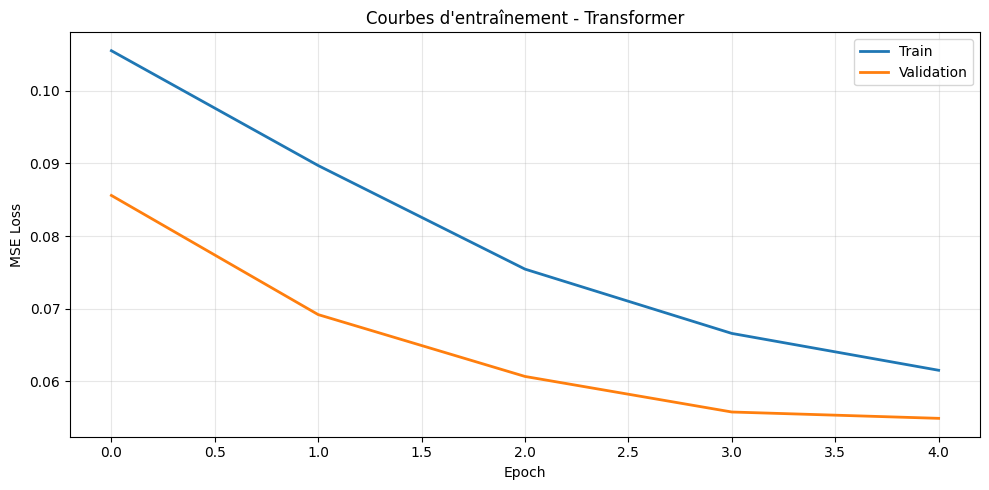

In [14]:
# Courbes d'entraînement
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train', linewidth=2)
ax.plot(val_losses, label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Courbes d\'entraînement - Transformer')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Évaluation finale

In [15]:
# Charger le meilleur modèle
model.load_state_dict(torch.load('../outputs/best_transformer.pt', map_location=DEVICE, weights_only=True))
val_loss, y_pred, y_test = eval_epoch(model, test_loader, criterion, DEVICE)

# Métriques
mse_x = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse_y = mean_squared_error(y_test[:, 1], y_pred[:, 1])
mae_x = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_y = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_x = r2_score(y_test[:, 0], y_pred[:, 0])
r2_y = r2_score(y_test[:, 1], y_pred[:, 1])
eucl_errors = np.sqrt((y_test[:, 0] - y_pred[:, 0])**2 + (y_test[:, 1] - y_pred[:, 1])**2)

print('=== Transformer ===')
print(f'  MSE  : X={mse_x:.5f}, Y={mse_y:.5f}')
print(f'  MAE  : X={mae_x:.4f}, Y={mae_y:.4f}')
print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')

=== Transformer ===
  MSE  : X=0.06052, Y=0.04944
  MAE  : X=0.1979, Y=0.1685
  R²   : X=0.3177, Y=0.5180
  Eucl : mean=0.2858, median=0.2601, p90=0.5203


## 9. Visualisations

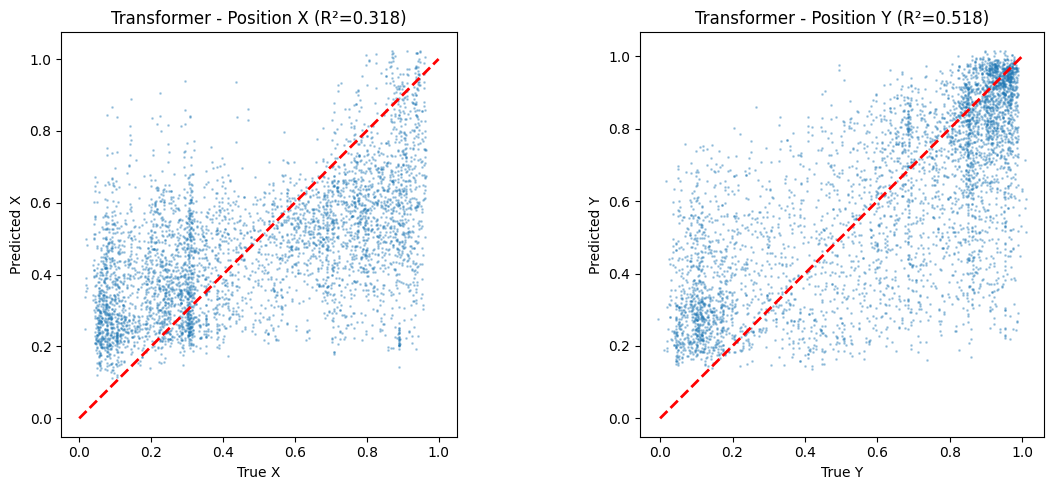

In [16]:
# --- Scatter pred vs true ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=1, alpha=0.3)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('True X'); axes[0].set_ylabel('Predicted X')
axes[0].set_title(f'Transformer - Position X (R²={r2_x:.3f})')
axes[0].set_aspect('equal')

axes[1].scatter(y_test[:, 1], y_pred[:, 1], s=1, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('True Y'); axes[1].set_ylabel('Predicted Y')
axes[1].set_title(f'Transformer - Position Y (R²={r2_y:.3f})')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

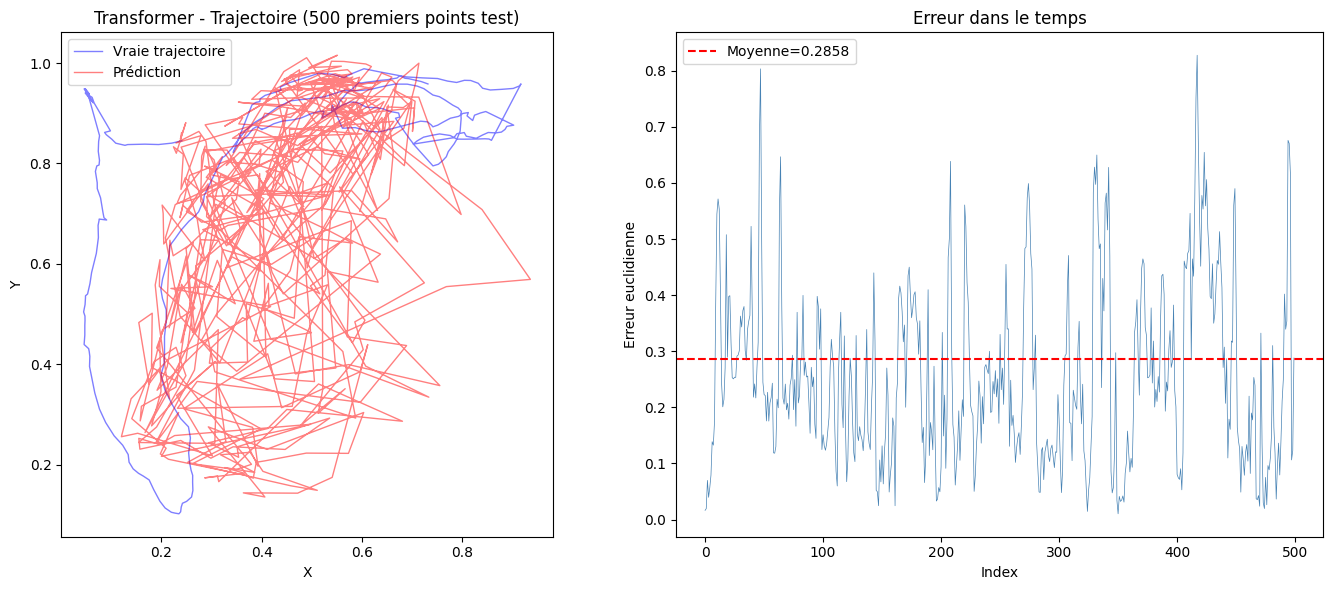

In [17]:
# --- Trajectoire prédite vs vraie ---
segment = slice(0, 500)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot(y_test[segment, 0], y_test[segment, 1], 'b-', alpha=0.5, label='Vraie trajectoire', linewidth=1)
axes[0].plot(y_pred[segment, 0], y_pred[segment, 1], 'r-', alpha=0.5, label='Prédiction', linewidth=1)
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
axes[0].set_title('Transformer - Trajectoire (500 premiers points test)')
axes[0].legend()
axes[0].set_aspect('equal')

axes[1].plot(eucl_errors[segment], color='steelblue', linewidth=0.5)
axes[1].axhline(eucl_errors.mean(), color='red', linestyle='--', label=f'Moyenne={eucl_errors.mean():.4f}')
axes[1].set_xlabel('Index'); axes[1].set_ylabel('Erreur euclidienne')
axes[1].set_title('Erreur dans le temps')
axes[1].legend()

plt.tight_layout()
plt.show()

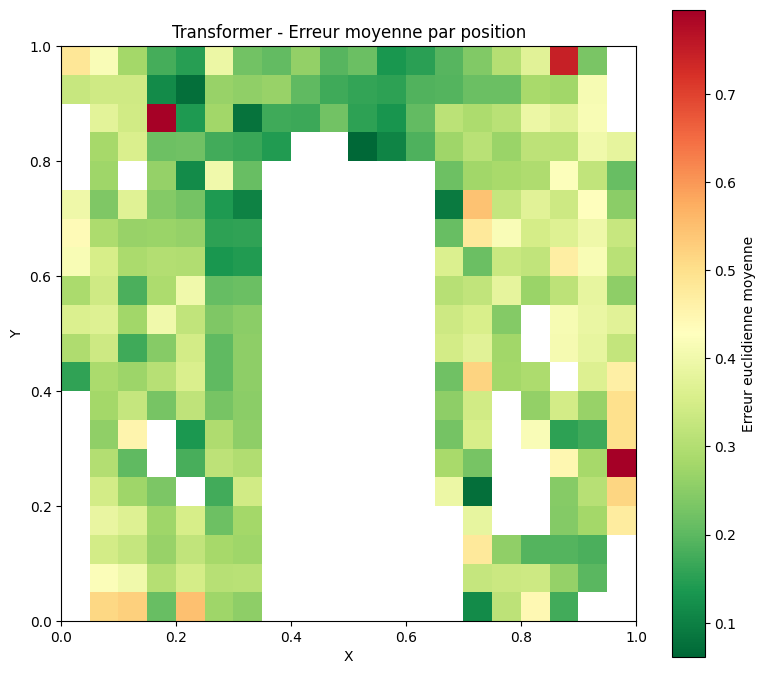

In [18]:
# --- Heatmap des erreurs spatiales ---
fig, ax = plt.subplots(figsize=(8, 7))

nbins = 20
error_map = np.full((nbins, nbins), np.nan)
count_map = np.zeros((nbins, nbins))
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for i in range(len(y_test)):
    xi = np.clip(np.searchsorted(x_edges, y_test[i, 0]) - 1, 0, nbins - 1)
    yi = np.clip(np.searchsorted(y_edges, y_test[i, 1]) - 1, 0, nbins - 1)
    if np.isnan(error_map[yi, xi]):
        error_map[yi, xi] = 0
    error_map[yi, xi] += eucl_errors[i]
    count_map[yi, xi] += 1

mean_error_map = np.where(count_map > 0, error_map / count_map, np.nan)

im = ax.imshow(mean_error_map, origin='lower', aspect='equal', cmap='RdYlGn_r', extent=[0, 1, 0, 1])
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('Transformer - Erreur moyenne par position')
plt.colorbar(im, ax=ax, label='Erreur euclidienne moyenne')
plt.tight_layout()
plt.show()

## 10. Sauvegarde des prédictions

In [19]:
np.save('../outputs/preds_transformer.npy', y_pred)
np.save('../outputs/y_test_transformer.npy', y_test)  # devrait être identique à y_test.npy
print('Prédictions Transformer sauvegardées.')

Prédictions Transformer sauvegardées.


## 11. Post-processing : Filtre de Kalman

On applique le même filtre de Kalman que dans le notebook 1. Le Transformer donne déjà de meilleures prédictions brutes que XGBoost — le Kalman devrait donc être encore plus efficace ici, puisqu'il lisse des prédictions déjà plus proches de la réalité.

In [20]:
# --- Filtre de Kalman ---
def kalman_smooth(observations, process_noise=0.001, measurement_noise=0.01):
    """Filtre de Kalman 2D (x, y) avec modèle de position constante."""
    N = len(observations)
    smoothed = np.zeros_like(observations)
    x_est = observations[0].copy()
    P = np.eye(2) * measurement_noise
    Q = np.eye(2) * process_noise
    R = np.eye(2) * measurement_noise
    for t in range(N):
        # Prédiction (modèle = position constante)
        x_pred = x_est
        P_pred = P + Q
        # Mise à jour
        z = observations[t]
        y_innov = z - x_pred
        S = P_pred + R
        K = P_pred @ np.linalg.inv(S)
        x_est = x_pred + K @ y_innov
        P = (np.eye(2) - K) @ P_pred
        smoothed[t] = x_est
    return smoothed

# Configurations Kalman
kalman_configs = {
    'Kalman léger':  {'process_noise': 0.005, 'measurement_noise': 0.005},
    'Kalman moyen':  {'process_noise': 0.001, 'measurement_noise': 0.02},
    'Kalman fort':   {'process_noise': 0.0005, 'measurement_noise': 0.05},
}

kalman_results = {}
print('=== Transformer brut ===')
print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')
print()

for name, params_k in kalman_configs.items():
    y_smooth = kalman_smooth(y_pred, **params_k)
    r2_sx = r2_score(y_test[:, 0], y_smooth[:, 0])
    r2_sy = r2_score(y_test[:, 1], y_smooth[:, 1])
    eucl_s = np.sqrt((y_test[:, 0] - y_smooth[:, 0])**2 + (y_test[:, 1] - y_smooth[:, 1])**2)
    kalman_results[name] = {'y_smooth': y_smooth, 'r2_x': r2_sx, 'r2_y': r2_sy, 'eucl': eucl_s}
    print(f'=== {name} (Q={params_k["process_noise"]}, R={params_k["measurement_noise"]}) ===')
    print(f'  R²   : X={r2_sx:.4f}, Y={r2_sy:.4f}')
    print(f'  Eucl : mean={eucl_s.mean():.4f}, median={np.median(eucl_s):.4f}, p90={np.percentile(eucl_s, 90):.4f}')
    print()

# Sauvegarder la meilleure version Kalman
best_kalman = min(kalman_results.items(), key=lambda x: x[1]['eucl'].mean())
print(f'Meilleur Kalman : {best_kalman[0]} (eucl mean={best_kalman[1]["eucl"].mean():.4f})')
np.save('../outputs/preds_transformer_kalman.npy', best_kalman[1]['y_smooth'])

=== Transformer brut ===
  R²   : X=0.3177, Y=0.5180
  Eucl : mean=0.2858, median=0.2601, p90=0.5203

=== Kalman léger (Q=0.005, R=0.005) ===
  R²   : X=0.3693, Y=0.5607
  Eucl : mean=0.2766, median=0.2595, p90=0.4866

=== Kalman moyen (Q=0.001, R=0.02) ===
  R²   : X=0.4398, Y=0.6103
  Eucl : mean=0.2667, median=0.2600, p90=0.4330

=== Kalman fort (Q=0.0005, R=0.05) ===
  R²   : X=0.4574, Y=0.6058
  Eucl : mean=0.2706, median=0.2654, p90=0.4175

Meilleur Kalman : Kalman moyen (eucl mean=0.2667)


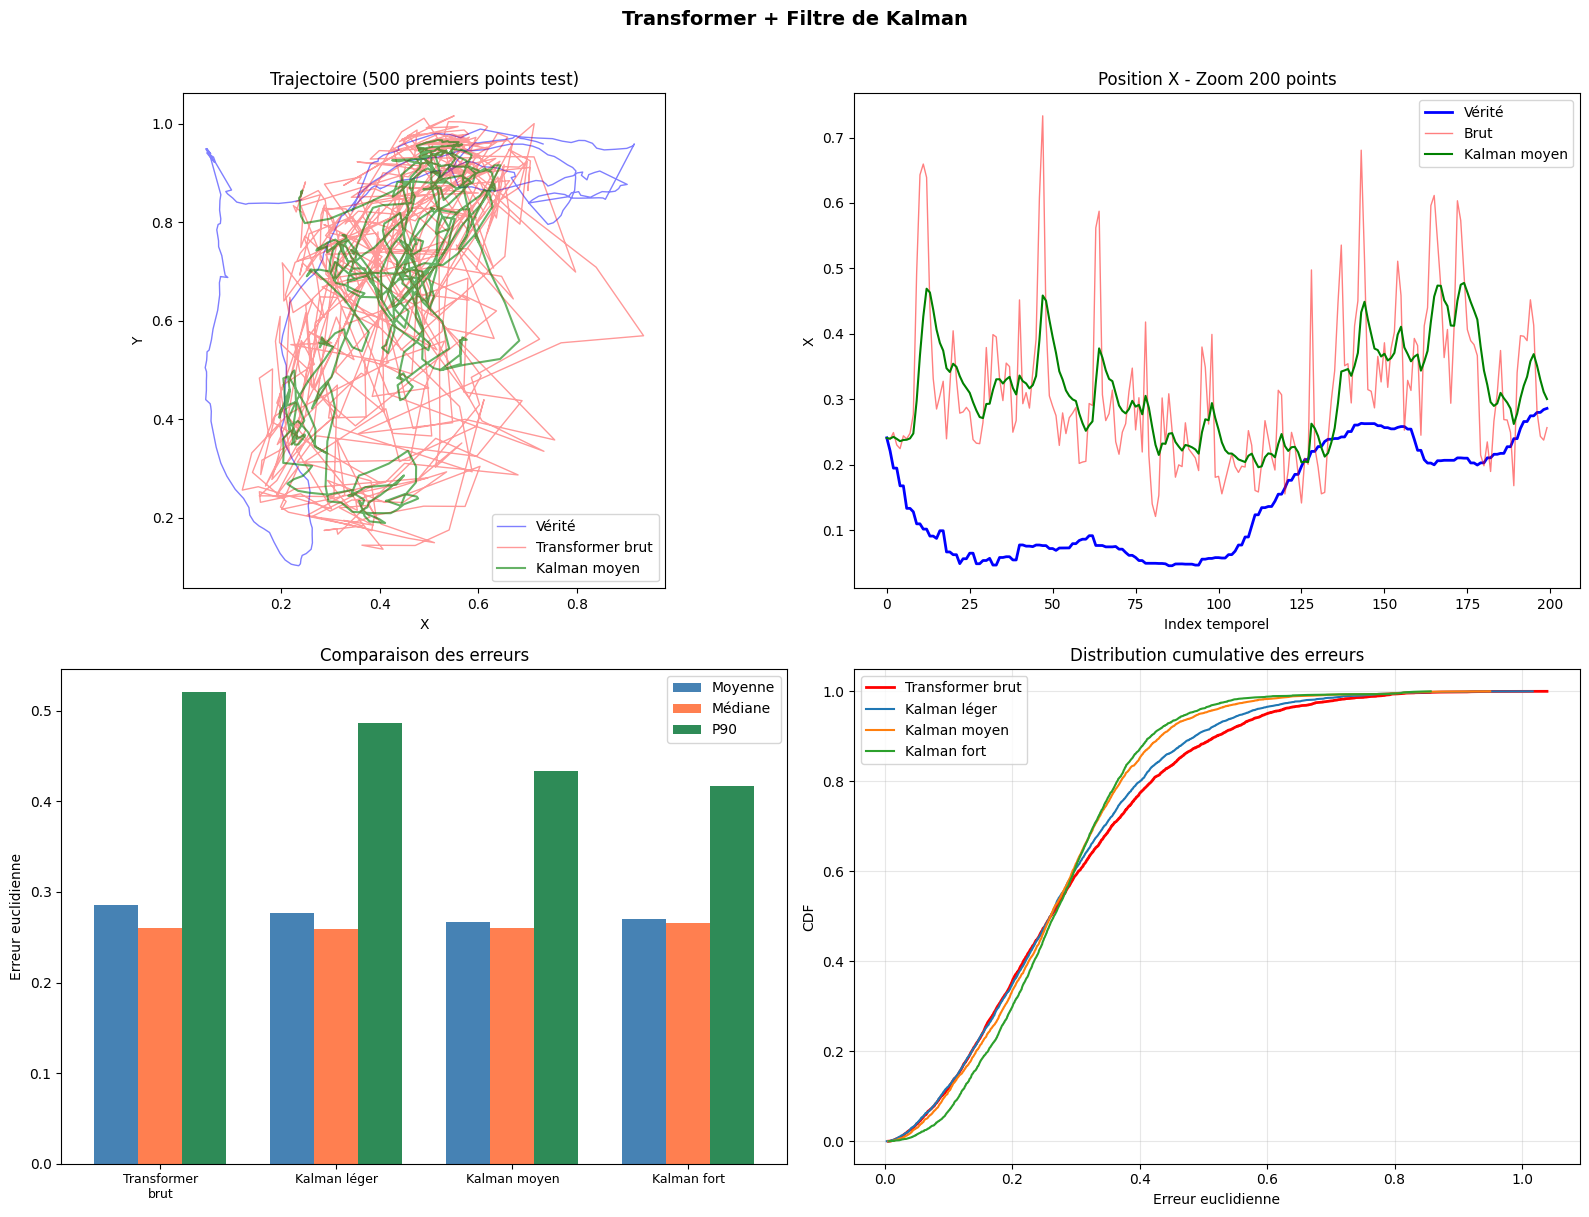

In [21]:
# --- Visualisation Kalman ---
best_name = best_kalman[0]
y_kalman = best_kalman[1]['y_smooth']
eucl_kalman = best_kalman[1]['eucl']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
seg = slice(0, 500)

# 1. Trajectoire comparée
ax = axes[0, 0]
ax.plot(y_test[seg, 0], y_test[seg, 1], 'b-', alpha=0.5, label='Vérité', linewidth=1)
ax.plot(y_pred[seg, 0], y_pred[seg, 1], 'r-', alpha=0.4, label='Transformer brut', linewidth=1)
ax.plot(y_kalman[seg, 0], y_kalman[seg, 1], 'g-', alpha=0.6, label=best_name, linewidth=1.5)
ax.set_xlabel('X'); ax.set_ylabel('Y')
ax.set_title('Trajectoire (500 premiers points test)')
ax.legend(); ax.set_aspect('equal')

# 2. Position X dans le temps
ax = axes[0, 1]
t_idx = np.arange(200)
ax.plot(t_idx, y_test[t_idx, 0], 'b-', label='Vérité', linewidth=2)
ax.plot(t_idx, y_pred[t_idx, 0], 'r-', alpha=0.5, label='Brut', linewidth=1)
ax.plot(t_idx, y_kalman[t_idx, 0], 'g-', label=best_name, linewidth=1.5)
ax.set_xlabel('Index temporel'); ax.set_ylabel('X')
ax.set_title('Position X - Zoom 200 points')
ax.legend()

# 3. Comparaison des erreurs par configuration
ax = axes[1, 0]
names = ['Transformer\nbrut'] + list(kalman_results.keys())
means = [eucl_errors.mean()] + [v['eucl'].mean() for v in kalman_results.values()]
medians = [np.median(eucl_errors)] + [np.median(v['eucl']) for v in kalman_results.values()]
p90s = [np.percentile(eucl_errors, 90)] + [np.percentile(v['eucl'], 90) for v in kalman_results.values()]

x_pos = np.arange(len(names))
w = 0.25
ax.bar(x_pos - w, means, w, label='Moyenne', color='steelblue')
ax.bar(x_pos, medians, w, label='Médiane', color='coral')
ax.bar(x_pos + w, p90s, w, label='P90', color='seagreen')
ax.set_xticks(x_pos); ax.set_xticklabels(names, fontsize=9)
ax.set_ylabel('Erreur euclidienne')
ax.set_title('Comparaison des erreurs')
ax.legend()

# 4. CDF des erreurs
ax = axes[1, 1]
sorted_brut = np.sort(eucl_errors)
ax.plot(sorted_brut, np.linspace(0, 1, len(sorted_brut)), 'r-', label='Transformer brut', linewidth=2)
for name, res in kalman_results.items():
    sorted_k = np.sort(res['eucl'])
    ax.plot(sorted_k, np.linspace(0, 1, len(sorted_k)), label=name, linewidth=1.5)
ax.set_xlabel('Erreur euclidienne'); ax.set_ylabel('CDF')
ax.set_title('Distribution cumulative des erreurs')
ax.legend(); ax.grid(True, alpha=0.3)

plt.suptitle('Transformer + Filtre de Kalman', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## 12. Interprétation

### Ce que le Transformer apporte

Contrairement à l'approche feature engineering, le Transformer travaille directement sur les **waveforms bruts** et peut capturer :
- Les **formes de spike** spécifiques à différents neurones (via le CNN encoder)
- Les **co-activations** entre spikes de différents shanks (via le self-attention)
- L'**ordre temporel** des spikes dans la séquence (via le positional encoding)

### Effet du filtre de Kalman

Le Kalman lisse les prédictions en exploitant la cohérence temporelle de la trajectoire. Comme les prédictions brutes du Transformer sont déjà meilleures que celles du XGBoost, le Kalman part d'une meilleure base. On s'attend à :
- Une réduction de l'erreur moyenne et surtout des pires cas (p90)
- Un gain en R² grâce à l'élimination du bruit haute fréquence
- Le Kalman "moyen" ou "fort" devrait être le meilleur compromis, car le Transformer produit des prédictions suffisamment bonnes pour que le lissage ne retarde pas trop

### Limites
- 22k exemples c'est peu pour un Transformer → risque d'overfitting malgré le dropout et le weight decay
- La troncature à 128 spikes perd de l'information pour les fenêtres très actives
- Le padding à 6 canaux pour les shanks à 4 canaux introduit des zéros qui ne sont pas informatifs
- Le Kalman introduit un léger retard temporel (lag) — le compromis biais/lissage dépend du paramètre R

### Améliorations possibles
- Augmenter le nombre d'epochs (actuellement 5, le modèle n'a probablement pas convergé)
- Data augmentation (bruit sur les waveforms, masquage aléatoire de spikes)
- Sortie probabiliste (MDN ou MC Dropout) pour la confiance
- Pre-training sur les exemples immobiles (self-supervised)
- Kalman avec modèle de vitesse constante (au lieu de position constante) pour mieux gérer les déplacements rapides